# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [15]:
# Load pickled data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
import math
import tensorflow as tf
%matplotlib inline

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [16]:
### To start off let's do a basic data summary.

n_train = len(X_train)

n_test = len(X_test)

x_dimension = len(X_train[0])
y_dimension = len(X_train[0][0])

n_classes = np.amax(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", x_dimension, y_dimension)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32 32
Number of classes = 43


## Data exploration and visualization
I am just using some randomized visualization of a set of traffic signs. Setting the image limit to 20 so it doesn't show a `plt` warning.

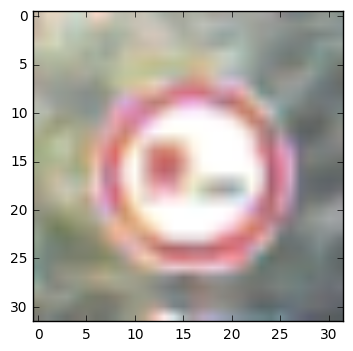

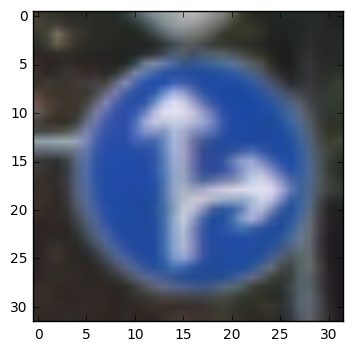

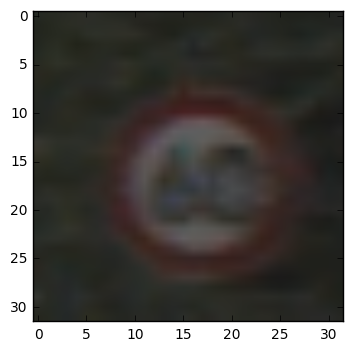

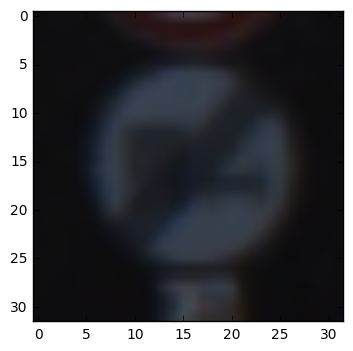

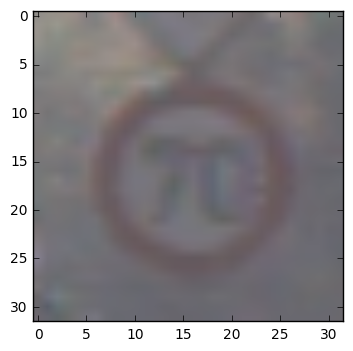

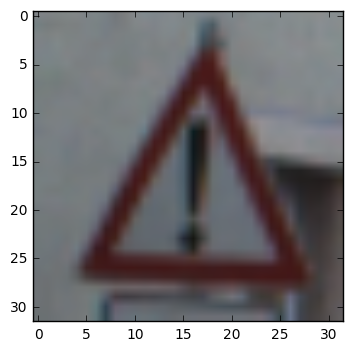

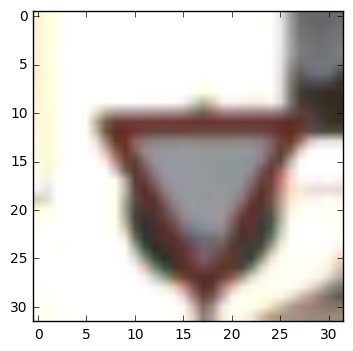

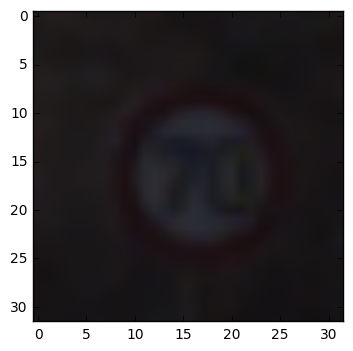

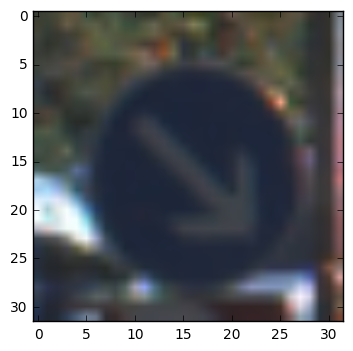

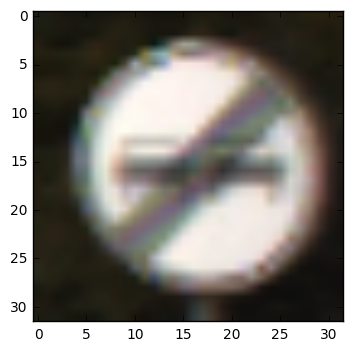

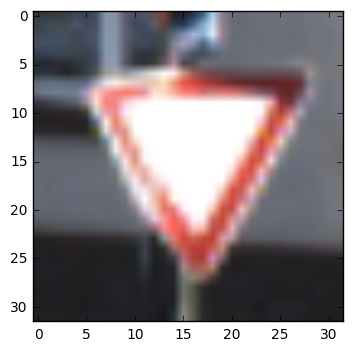

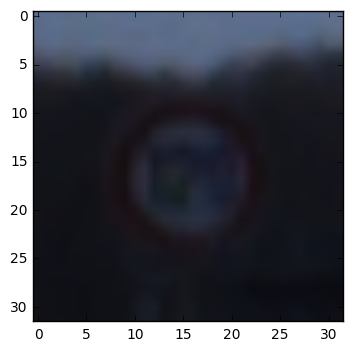

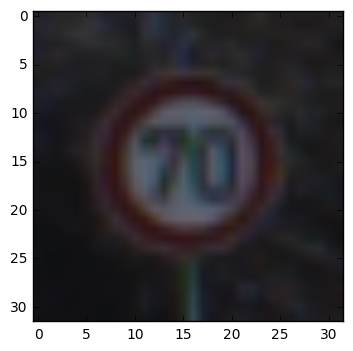

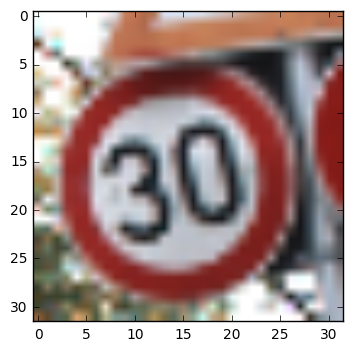

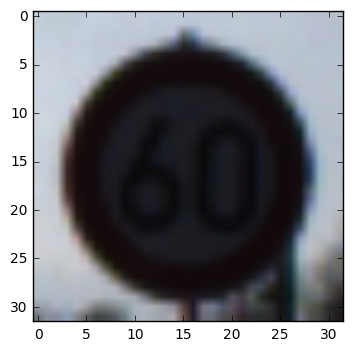

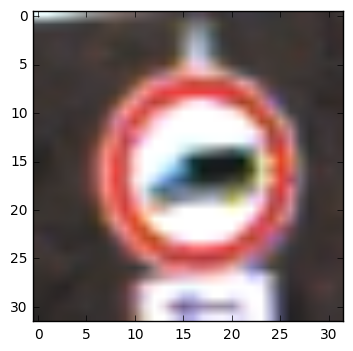

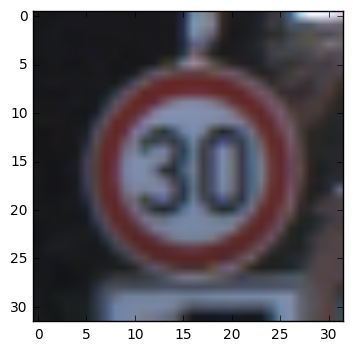

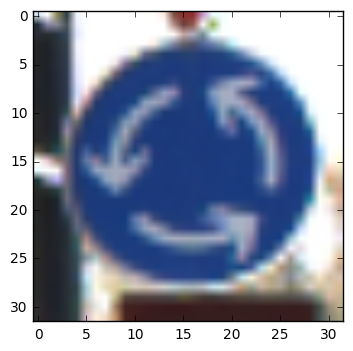

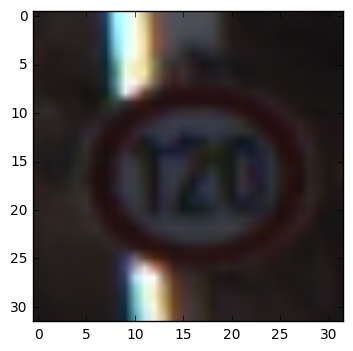

In [17]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

n_examples = 20

def show_random_images(images):
    for i in range(n_examples):
        image = images[random.randrange(len(images))]

        plt.imshow(image, cmap='gray')
        plt.figure(i + 1)
        
show_random_images(X_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

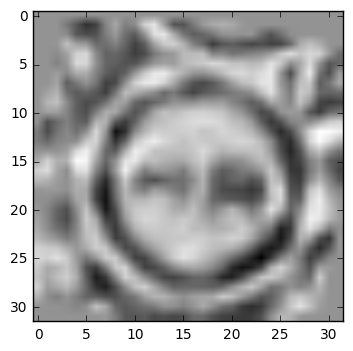

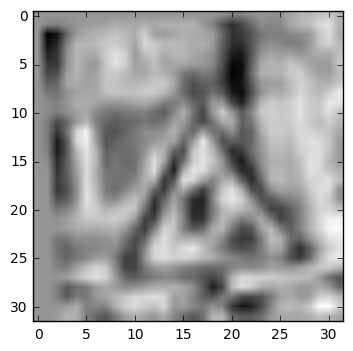

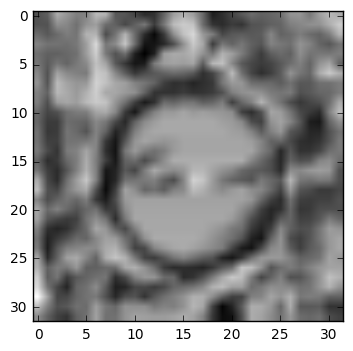

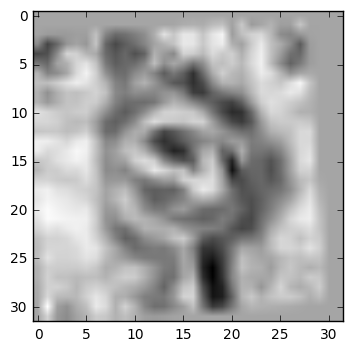

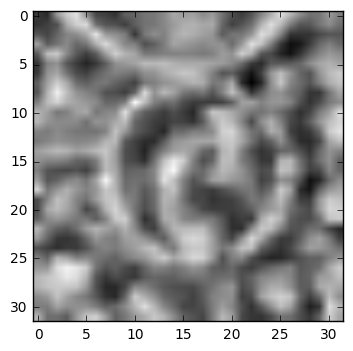

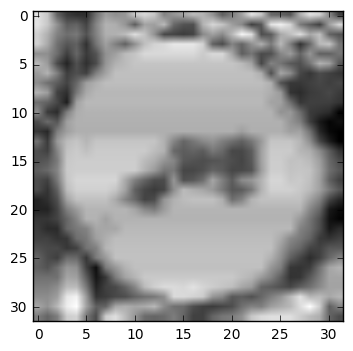

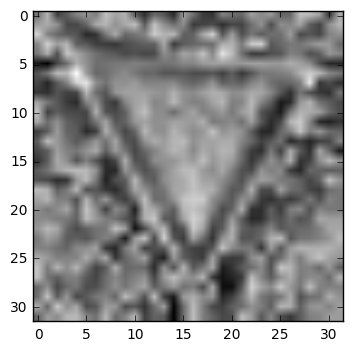

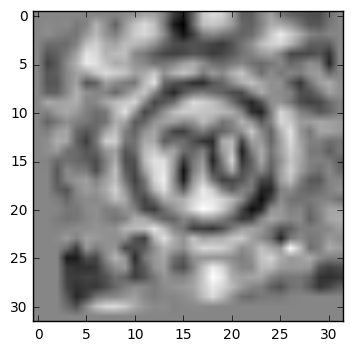

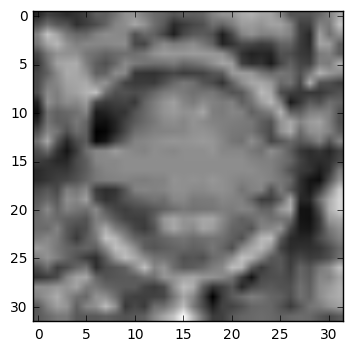

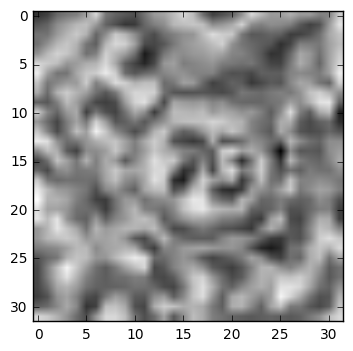

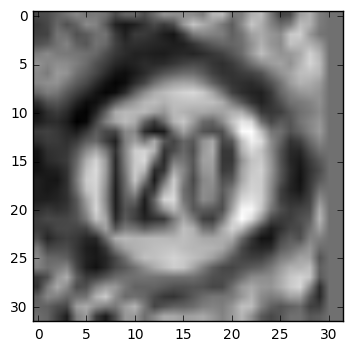

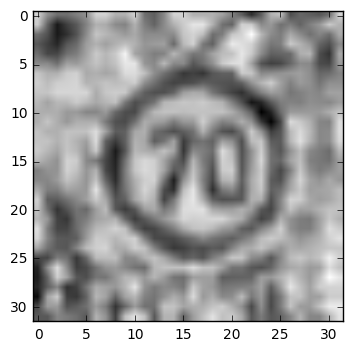

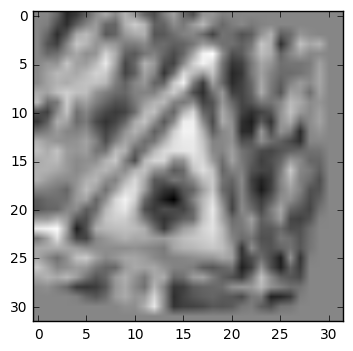

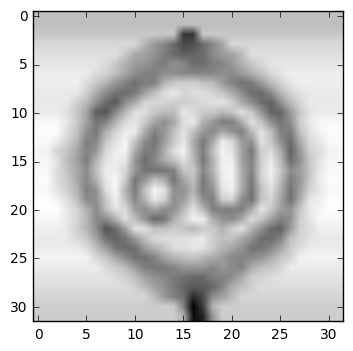

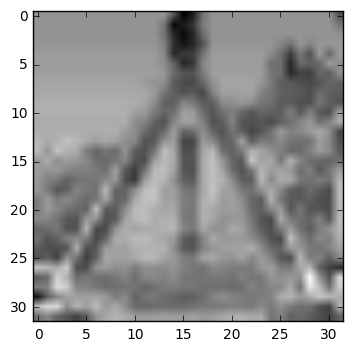

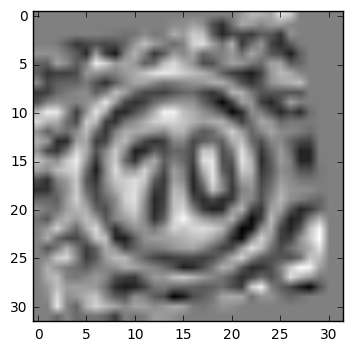

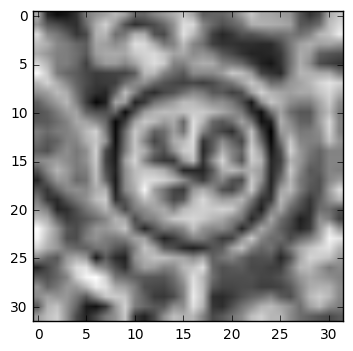

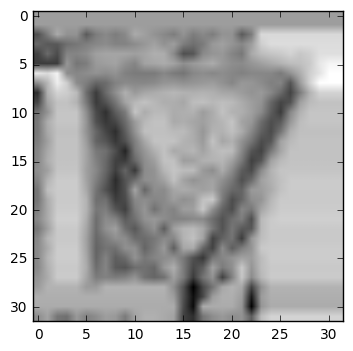

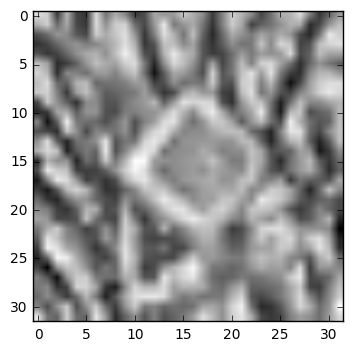

In [18]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
    
def transform_grey(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def get_n_img_per_class(labels):
    n_img_per_class = []
    current_y = 0
    current_count = 0

    for y in labels:
        if y == current_y:
            current_count += 1
        else:
            current_y = y
            n_img_per_class.append(current_count)
            current_count = 1

    n_img_per_class.append(current_count)
    return n_img_per_class

def extract_validation_set(X_train, y_train):
    n_img_per_class = get_n_img_per_class(y_train)
    
    new_X_train = np.copy(X_train)
    new_y_train = np.copy(y_train)
    X_validate = []
    y_validate = []
    start_index = 0
    
    # TODO: OPTIMIZE THIS SHIT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    for n_img in n_img_per_class:
        n_picks = int(n_img / 10)    
        current_n_img = n_img
    
        for i in range(n_picks):
            index = random.randrange(start_index, start_index + current_n_img)
            X_validate.append(new_X_train[index])
            y_validate.append(new_y_train[index])

            new_X_train = np.append(new_X_train[:index], new_X_train[index + 1:])
            new_y_train = np.append(new_y_train[:index], new_y_train[index + 1:])
            current_n_img -= 1
        
        start_index += current_n_img
    
    return {
        'X_train': new_X_train,
        'Y_train': new_y_train,
        'X_validate': X_validate,
        'y_validate': y_validate
    }
    
def rotate_image(img, angle):
    rows, cols = img.shape
     
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

def translate_image(img, translation_x, translation_y):
    rows, cols = img.shape
     
    M = np.float32([[1,0,translation_x],[0,1,translation_y]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

def scale_image(img, scale):
    rows, cols = img.shape
    res = cv2.resize(img,None,fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)
    new_rows, new_cols = res.shape
    
    if (scale > 1):
        res = res[int(new_rows / 2) - 16:int(new_rows / 2) + 16, int(new_cols / 2) - 16:int(new_cols / 2) + 16]
    else:
        res = cv2.copyMakeBorder(res, math.ceil((32 - new_rows) / 2), int((32 - new_rows) / 2), math.ceil((32 - new_cols) / 2), int((32 - new_cols) / 2), cv2.BORDER_CONSTANT, value=[0,0,0])
    
    return res

def add_jitter(image):
    jitter_image = scale_image(image, random.uniform(0.9, 1.1))
    jitter_image = rotate_image(jitter_image, random.uniform(-15.0, 15.0))
    jitter_image = translate_image(jitter_image, random.randrange(-2,2), random.randrange(-2,2))
    return jitter_image

# Taken from https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/expr/preprocessing.py
def contrast_normalize(X, scale=1., subtract_mean=True, use_std=True, sqrt_bias=10., min_divisor=1e-8):
    """
    Global contrast normalizes by (optionally) subtracting the mean
    across features and then normalizes by either the vector norm
    or the standard deviation (across features, for each example).
    Parameters
    ----------
    X : ndarray, 2-dimensional
        Design matrix with examples indexed on the first axis and \
        features indexed on the second.
    scale : float, optional
        Multiply features by this const.
    subtract_mean : bool, optional
        Remove the mean across features/pixels before normalizing. \
        Defaults to `True`.
    use_std : bool, optional
        Normalize by the per-example standard deviation across features \
        instead of the vector norm. Defaults to `False`.
    sqrt_bias : float, optional
        Fudge factor added inside the square root. Defaults to 0.
    min_divisor : float, optional
        If the divisor for an example is less than this value, \
        do not apply it. Defaults to `1e-8`.
    Returns
    -------
    Xp : ndarray, 2-dimensional
        The contrast-normalized features.
    Notes
    -----
    `sqrt_bias` = 10 and `use_std = True` (and defaults for all other
    parameters) corresponds to the preprocessing used in [1].
    References
    ----------
    .. [1] A. Coates, H. Lee and A. Ng. "An Analysis of Single-Layer
       Networks in Unsupervised Feature Learning". AISTATS 14, 2011.
       http://www.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf
    """
    assert X.ndim == 2, "X.ndim must be 2"
    scale = float(scale)
    assert scale >= min_divisor
    
    # First, local contrast normalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    X = clahe.apply(X)
    
    # Note: this is per-example mean across pixels, not the
    # per-pixel mean across examples. So it is perfectly fine
    # to subtract this without worrying about whether the current
    # object is the train, valid, or test set.
    mean = X.mean(axis=1)
    if subtract_mean:
        X = X - mean[:, np.newaxis]  # Makes a copy.
    else:
        X = X.copy()
    
    if use_std:
        # ddof=1 simulates MATLAB's var() behaviour, which is what Adam
        # Coates' code does.
        ddof = 1
        
        # If we don't do this, X.var will return nan.
        if X.shape[1] == 1:
            ddof = 0
        
        normalizers = np.sqrt(sqrt_bias + X.var(axis=1, ddof=ddof)) / scale
    else:
        normalizers = np.sqrt(sqrt_bias + (X ** 2).sum(axis=1)) / scale
    
    # Don't normalize by anything too small.
    normalizers[normalizers < min_divisor] = 1.
    
    X /= normalizers[:, np.newaxis]  # Does not make a copy.
    return X

def prepare_data(X):
    # Preliminary: transform all images into YUV format, only take Y
    X_grey = np.array(list(map(transform_grey, X)))
    
    # Finally, we do global and local contrast normalization for the images
    X_norm = np.array(list(map(contrast_normalize, X_grey)))
    
    return X_norm


# -------------- DATA PREP PIPELINE

# First, we do global and local contrast normalization for the images

X_train_prep = prepare_data(X_train)
X_test_prep = prepare_data(X_test)

# Then, validation set selected at random per class
# Validation set extraction:
# validate_set = extract_validation_set(X_train_prep, y_train)

# X_train_remaining = validate_set['X_train']
# y_train = validate_set['y_train']

# X_validate = validate_set['X_validate']
# y_validate = validate_set['y_validate']

X_train_remaining = X_train_prep

# After we have the validation set, we generate jitter images of the remanining training set:
# Duplicate the X_train list by adding jitter
X_jitter = np.array(list(map(add_jitter, X_train_remaining)))
y_jitter = y_train

X_train_and_jitter = np.append(X_train_remaining, X_jitter, 0)

show_random_images(X_train_and_jitter)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
YUV channel, local and global normalization for Y channel. UV channels ditched for faster training. Most important tradeoff: quick training at the expense of loss, I don't have powerful equipment with me. That's why I decided not to pursue the generation of a jittered dataset either.

Combining 108-108 features (108 first stage, 108 second stage), 50 hidden units and no color performed best on the validation set, 2-stage classifier reaching 0.31% error.

Each convolution connection table has a density of approximately 70-80%, i.e. 108-8640

2-layer (fully connected) classifier with the following number of hidden units: 50

LEARNING RATE? TBD
REGULARIZATION VALUES? TBD

tanh for nonlinear layers, the other method looks fucking difficult

I thought about applying CLAHE from OpenCV, but features definitely look less clear.

In [19]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

"""
LeNet Architecture

HINTS for layers:

    Convolutional layers:

    tf.nn.conv2d
    tf.nn.max_pool

    For preparing the convolutional layer output for the
    fully connected layers.

    tf.contrib.flatten
"""
from tensorflow.contrib.layers import flatten

# LeNet architecture:
# INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC
#
# Don't worry about anything else in the file too much, all you have to do is
# create the LeNet and return the result of the last fully connected layer.
def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 28, 28, 1))
    # Squish values from 0-255 to 0-1.
    x /= 255.
    # Resize to 32x32.
    x = tf.image.resize_images(x, (32, 32))

    # TODO: Define the LeNet architecture. INPUT: 32x32x1

    # C1: 28x28x6
    stride_c1 = 1
    filter_dimension_c1 = 5
    filter_depth_c1 = 6
    F_W_c1 = tf.Variable(tf.truncated_normal((filter_dimension_c1, filter_dimension_c1, 1, filter_depth_c1)))
    F_b_c1 = tf.Variable(tf.zeros(filter_depth_c1))
    strides_c1 = [1, stride_c1, stride_c1, 1]
    padding_c1 = 'VALID'

    x = tf.nn.conv2d(x, F_W_c1, strides_c1, padding_c1) + F_b_c1

    # A1:
    x = tf.nn.relu(x)

    # MP1: 14x14x6
    strides_mp1 = [1, 2, 2, 1]
    filter_dimension_mp1 = 2
    padding_mp1 = 'VALID'

    x = tf.nn.max_pool(x, [1, filter_dimension_mp1, filter_dimension_mp1, 1], strides_mp1, padding_mp1)

    # C2: 10x10x16
    stride_c2 = 1
    filter_dimension_c2 = 5
    filter_depth_c2 = 16
    F_W_c2 = tf.Variable(tf.truncated_normal((filter_dimension_c2, filter_dimension_c2, filter_depth_c1, filter_depth_c2)))
    F_b_c2 = tf.Variable(tf.zeros(filter_depth_c2))
    strides_c2 = [1, stride_c2, stride_c2, 1]
    padding_c2 = 'VALID'

    x = tf.nn.conv2d(x, F_W_c2, strides_c2, padding_c2) + F_b_c2

    # A2:
    x = tf.nn.relu(x)

    # MP2: 5x5x16
    strides_mp2 = [1, 2, 2, 1]
    filter_dimension_mp2 = 2
    padding_mp2 = 'VALID'

    x = tf.nn.max_pool(x, [1, filter_dimension_mp2, filter_dimension_mp2, 1], strides_mp2, padding_mp2)

    # FLATTEN
    x = flatten(x)

    # FC1: 400->120
    F_W_fc1 = tf.Variable(tf.random_normal((x.get_shape().as_list()[-1], 120)))
    F_b_fc1 = tf.Variable(tf.zeros(120))
    x = tf.add(tf.matmul(x, F_W_fc1), F_b_fc1)

    # A3:
    x = tf.nn.relu(x)

    # FC2: 120->10
    F_W_fc2 = tf.Variable(tf.random_normal((120, 10)))
    F_b_fc2 = tf.Variable(tf.zeros(10))
    x = tf.add(tf.matmul(x, F_W_fc2), F_b_fc2)

    # Return the result of the last fully connected layer.
    return x

class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.current_batch_index = 0
        
    def next_batch(batch_size):
        batch_X, batch_y = self.X[self.current_batch_index:self.current_batch_index + batch_size], self.y[self.current_batch_index:self.current_batch_index + batch_size]
        self.current_batch_index += batch_size
        return batch_X, batch_y

def eval_data(dataset):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    steps_per_epoch = len(dataset.X) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = dataset.next_batch()
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

def one_hot(y, n_labels):
    return tf.one_hot(y, n_labels)

# NOTE: Feel free to change these.
EPOCHS = 10
BATCH_SIZE = 64

# Load data
train_dataset = Dataset(X_train, one_hot(y_train, n_classes))
validate_dataset = Dataset(X_validate, one_hot(y_validate, n_classes))
test_dataset = Dataset(X_test, one_hot(y_test, n_classes))

# Dataset consists of 32x32x1, grayscale images.
x = tf.placeholder(tf.float32, (None, 1024))
# Classify over number of classes (43).
y = tf.placeholder(tf.float32, (None, n_classes))
# Create the LeNet.
fc2 = LeNet(x)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    steps_per_epoch = len(train_dataset.X) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE

    # Train model
    for i in range(EPOCHS):
        for step in range(steps_per_epoch):
            batch_X, batch_y = train_dataset.next_batch()          
            loss = sess.run(train_op, feed_dict={x: batch_X, y: batch_y})

        val_loss, val_acc = eval_data(validate_dataset)
        print("EPOCH {} ...".format(i+1))
        print("Validation loss = {}".format(val_loss))
        print("Validation accuracy = {}".format(val_acc))

    # Evaluate on the test data
    test_loss, test_acc = eval_data(test_dataset)
    print("Test loss = {}".format(test_loss))
    print("Test accuracy = {}".format(test_acc))


NameError: name 'X_validate' is not defined

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.